In [1]:

# Torch
import torch
import torch.optim as optim
from torcheval.metrics import *
import torch.nn.functional as F
from torch.utils.data import DataLoader


# Benny pointnet
from pointnet2_benny import pointnet2_cls_ssg
import shutil
from sklearn.metrics import *

# Custom modules
from preprocessing_pre_fastsufer.preprocess import *
from preprocessing_post_fastsurfer.subject import *
from preprocessing_post_fastsurfer.vis import *
from ozzy_torch_utils.split_dataset import *
from ozzy_torch_utils.subject_dataset import *
from ozzy_torch_utils.plot import *
from ozzy_torch_utils.train_nn import *
from ozzy_torch_utils.model_parameters import *
from ozzy_torch_utils.init_dataloaders import *
from ensemble.combined_models import *

from explain_pointnet import get_prediction


In [2]:
data_path = "/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/scratch-disk/full-datasets/hcampus-1.5T-cohort-holdout"

In [3]:
subject_list = find_subjects_parallel(data_path)
    

Csv files: ['/uolstore/home/student_lnxhome01/sc22olj/Compsci/year3/individual-project-COMP3931/individual-project-sc22olj/scratch-disk/full-datasets/hcampus-1.5T-cohort-holdout/idaSearch_3_19_2025.csv']


In [4]:
for subject in subject_list:

    subject.data = {}

    # Group
    mapping = {
        'CN': 0,
        'MCI': 1,
    }

    # Get the value of the mapping, -1 if not found
    subject.data['research_group'] = mapping.get(subject.subject_metadata['Research Group'].iloc[0], -1)

    # Cloud
    subject.data['lhcampus_pointcloud_aligned'] = np.load(os.path.join(subject.path, 'Left-Hippocampus_aligned_cropped_mesh_downsampledcloud.npy'))

    # Volumes
    volume_col = subject.aseg_stats['Volume_mm3']
    volume_col_normalised = volume_col / volume_col.sum() * 1000
    struct_name_col = subject.aseg_stats['StructName']
    
    subject.data['volumes'] = np.array(volume_col_normalised)
    
    subject.data['struct_names'] = np.array(struct_name_col)

    # Scores
    mmse = subject.subject_metadata['MMSE Total Score'].iloc[0]
    gdscale = subject.subject_metadata['GDSCALE Total Score'].iloc[0]
    faq = subject.subject_metadata['FAQ Total Score'].iloc[0]
    npiq = subject.subject_metadata['NPI-Q Total Score'].iloc[0]

    subject.data['scores'] = [mmse, gdscale, faq, npiq]

    subject.data['score_names'] = ['MMSE Total Score', 'GDSCALE Total Score', 'FAQ Total Score', 'NPI-Q Total Score']

Evaluate pointnet

In [6]:
# WHY ARE THESE METRICS CHANGING ??
roc_auc = -np.inf

for seed in range(100):

    true = []
    pred_probs = []
    pred_classes = []

    for subject in subject_list:

        pred_research_group, pred_class, output = get_pointnet_prediction(subject.data['lhcampus_pointcloud_aligned'], 'cpu', seed=seed, mode = 'pth')

        true.append(subject.data['research_group'])
        
        pred_probs.append(output)

        pred_classes.append(pred_class)

    current_roc_auc = roc_auc_score(true, pred_probs) 

    print(roc_auc)

    if current_roc_auc > roc_auc:

        roc_auc = current_roc_auc

        best_seed = seed


-inf
0.6557971014492754
0.6557971014492754
0.6847826086956522
0.6847826086956522
0.6847826086956522
0.6847826086956522
0.6847826086956522
0.6847826086956522
0.6847826086956522
0.6847826086956522
0.6847826086956522
0.6847826086956522
0.6847826086956522
0.6847826086956522
0.6847826086956522
0.6847826086956522
0.6847826086956522
0.6847826086956522
0.6847826086956522
0.6847826086956522
0.6884057971014492
0.7028985507246376
0.7028985507246376
0.7028985507246376
0.7028985507246376
0.7028985507246376
0.7028985507246376
0.7028985507246376
0.7028985507246376
0.7028985507246376
0.7028985507246376
0.7028985507246376
0.7028985507246376
0.7028985507246376
0.7028985507246376
0.7028985507246376
0.7028985507246376
0.7028985507246376
0.7028985507246376
0.7028985507246376
0.7028985507246376
0.7028985507246376
0.7028985507246376
0.7028985507246376
0.7028985507246376
0.7028985507246376
0.7028985507246376
0.7028985507246376
0.7028985507246376
0.7028985507246376
0.7028985507246376
0.7028985507246376
0.70289

0.6594202898550725
0.6808510638297872


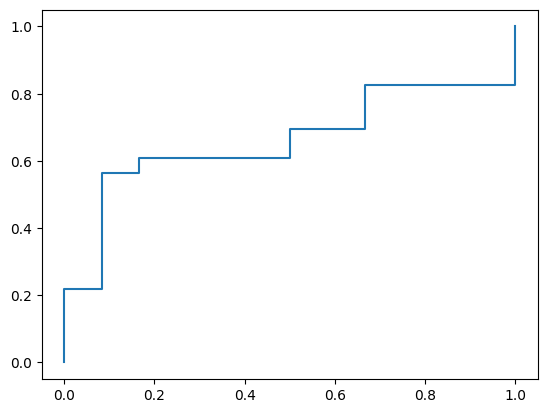

In [7]:
roc_auc = roc_auc_score(true, pred_probs)
print(roc_auc)

f1 = f1_score(true, pred_classes)
print(f1)

fpr, tpr, thresholds = roc_curve(true, pred_probs)

plt.plot(fpr, tpr)

plt.show()

Evaluate volumes gbdt

In [8]:
true = []
pred_probs = []
pred_classes = []

for subject in subject_list:

    pred_research_group, pred_class, output = get_volumes_prediction(subject.data['volumes'])

    true.append(subject.data['research_group'])
    
    pred_probs.append(output)

    pred_classes.append(pred_class)

0.8242753623188406
0.7931034482758621


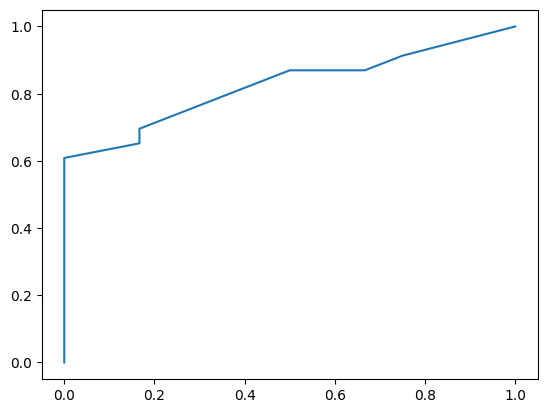

In [9]:
roc_auc = roc_auc_score(true, pred_probs)
print(roc_auc)

f1 = f1_score(true, pred_classes)
print(f1)

fpr, tpr, thresholds = roc_curve(true, pred_probs)

plt.plot(fpr, tpr)

plt.show()

Evaluate scores gbdt

In [10]:
true = []
pred_probs = []
pred_classes = []

for subject in subject_list:

    pred_research_group, pred_class, output = get_scores_prediction(subject.data['scores'])

    true.append(subject.data['research_group'])
    
    pred_probs.append(output)

    pred_classes.append(pred_class)

0.8007246376811594
0.7916666666666666


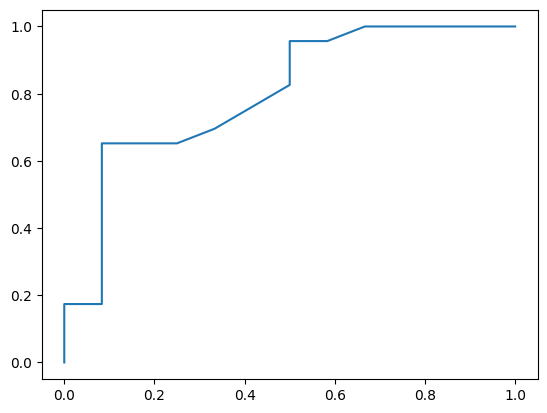

In [11]:
roc_auc = roc_auc_score(true, pred_probs)
print(roc_auc)

f1 = f1_score(true, pred_classes)
print(f1)

fpr, tpr, thresholds = roc_curve(true, pred_probs)

plt.plot(fpr, tpr)

plt.show()

Evaluate ensemble

In [12]:
true = []
pred_probs = []
pred_classes = []

for subject in subject_list:

    pred_research_group, pred_class, output = get_ensemble_prediction_avg(subject.data)

    true.append(subject.data['research_group'])
    
    pred_probs.append(output)

    pred_classes.append(pred_class)

0.7934782608695652
0.75


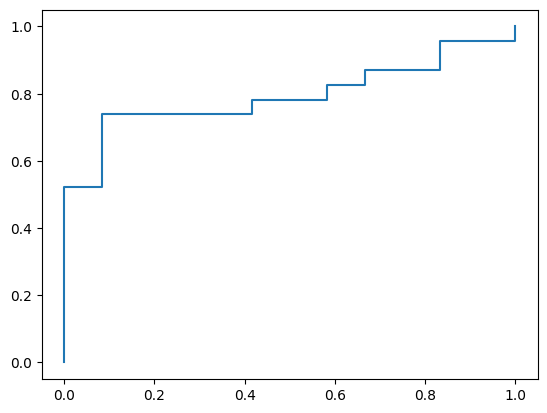

In [13]:
roc_auc = roc_auc_score(true, pred_probs)
print(roc_auc)

f1 = f1_score(true, pred_classes)
print(f1)

fpr, tpr, thresholds = roc_curve(true, pred_probs)

plt.plot(fpr, tpr)

plt.show()

In [14]:
true = []
pred_probs = []
pred_classes = []

models_used = []

for subject in subject_list:

    pred_research_group, pred_class, output, model = get_ensemble_prediction_maxprob(subject.data)

    true.append(subject.data['research_group'])
    
    pred_probs.append(output)

    pred_classes.append(pred_class)

    models_used.append(model)

(array([0, 1, 2]), array([17,  1, 17]))
0.7916666666666666
0.7659574468085106


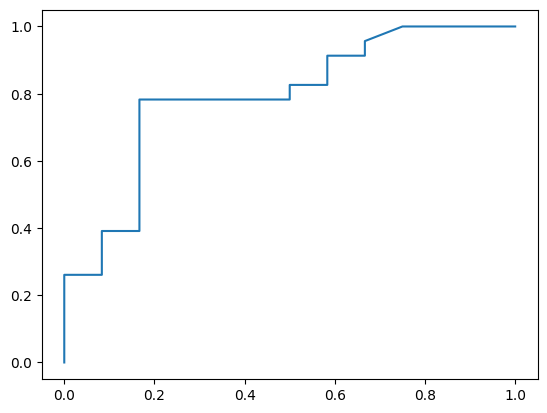

In [15]:
print(np.unique(models_used, return_counts=True))

roc_auc = roc_auc_score(true, pred_probs)
print(roc_auc)

f1 = f1_score(true, pred_classes)
print(f1)

fpr, tpr, thresholds = roc_curve(true, pred_probs)

plt.plot(fpr, tpr)

plt.show()